# 03 - Predictability & Universe Filtering

1. Compute rolling predictability metrics for each ticker
2. Visualize and compare scores across universe and time
3. Select top-N most “learnable” tickers for RL agent
4. Document all decisions, assumptions, and open questions


In [22]:
# SETUP: Imports & Paths ===========================
import jupyter

import os
import pandas as pd


from tqdm import tqdm
from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display


In [23]:
# LOAD OHLCV ==========================================
ohlcv_df = load_base_dataframe()
ohlcv_df.tail()
_ohlcv=ohlcv_df.copy()

In [ ]:
# CROP THE SAMPLE =======================================
tickers = ohlcv_df['ticker'].unique()

In [ ]:

all_metric = generate_universe_easiness_report(ohlcv_df,tickers)

In [ ]:
all_metric.dropna()

# Walkforward study

In [27]:

#ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
ohlcv_df = _ohlcv.copy()
# Walkforward parameters
start_date = pd.to_datetime('2023-05-01')
end_date = ohlcv_df['date'].max()
freq = '6MS'   # Month Start, use 'W' for weekly, etc
window_length = 60
#tickers = ohlcv_df['ticker'].unique()

walkforward_dates = pd.date_range(start=start_date + pd.Timedelta(days=window_length), end=end_date, freq=freq)


walkforward_dates

DatetimeIndex(['2023-07-01', '2024-01-01', '2024-07-01', '2025-01-01'], dtype='datetime64[ns]', freq='6MS')

In [31]:
prev_date = "2023-01-01"
tickers = ohlcv_df['symbol'].unique()
for cutoff in tqdm(walkforward_dates):
    
    cutoff_str = cutoff.strftime('%Y-%m-%d')
    
    print(f"\n=== Universe study up to {cutoff_str} ===")
    _ = generate_universe_easiness_report(
        ohlcv_df=ohlcv_df,
        tickers=tickers,
        window_length=window_length,
        target="return_1d",
        benchmark_col="market_return_1d",
        visualize=False,   # Skip plotting for speed, or True for debug
        cutoff_end_date=cutoff_str,
        cutoff_start_date=prev_date,
        save_csv_path="data/experiments/predictability_metrics-{hash}-{start}-{cutoff}.csv".format(hash="{hash}", cutoff=cutoff_str,start=prev_date)
    )
    prev_date = cutoff_str

  0%|          | 0/4 [00:00<?, ?it/s]


=== Universe study up to 2023-07-01 ===



  0%|          | 0/504 [00:00<?, ?it/s]

[WARNING] Metric rolling_variance_ration not recognized, skipping.


Model is not converging.  Current: 156.5235340127871 is not greater than 156.5258833066113. Delta is -0.0023492938241815864
Model is not converging.  Current: 158.4966534909004 is not greater than 158.4974729193101. Delta is -0.0008194284096987303
Model is not converging.  Current: 155.53314014447326 is not greater than 155.5620573464214. Delta is -0.028917201948132742
Model is not converging.  Current: 155.99037897781744 is not greater than 156.03208722875556. Delta is -0.04170825093811459
Model is not converging.  Current: 150.33310156548876 is not greater than 150.33334830781686. Delta is -0.0002467423281018455
Model is not converging.  Current: 154.9566456252006 is not greater than 154.95735931769659. Delta is -0.0007136924959922908
Model is not converging.  Current: 154.0093799293131 is not greater than 154.011464385817. Delta is -0.0020844565038942164
Model is not converging.  Current: 151.9604495382787 is not greater than 151.96595037637388. Delta is -0.0055008380951733216
Model

# Futures and nice to haves

In [1]:
import os
import pandas as pd
import json

EXPERIMENTS_DIR = "data/experiments"

# List all experiment result CSVs
all_files = [f for f in os.listdir(EXPERIMENTS_DIR) if f.startswith('predictability_metrics-') and f.endswith('.csv')]

studies = []
for fname in all_files:
    df = pd.read_csv(os.path.join(EXPERIMENTS_DIR, fname))
    # Parse config from first row (all rows have same config)
    config = json.loads(df['config_json'].iloc[0])
    studies.append({'df': df, 'config': config, 'hash': df['config_hash'].iloc[0], 'filename': fname})


C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
for study in studies:
    print(f"--- Study Hash: {study['hash']} | File: {study['filename']}")
    print(json.dumps(study['config'], indent=2))
    df = study['df']
    metrics = [col for col in df.columns if col not in ["ticker", "date", "config_hash", "config_json", "symbol"]]
    for metric in metrics:
        print(f"Metric: {metric}")
        print(f"  Mean: {df[metric].mean():.4f}, Std: {df[metric].std():.4f}")
        # Top and bottom tickers (by mean)
        agg = df.groupby('ticker')[metric].mean().sort_values(ascending=False)
        print("    Top 3 tickers:", agg.head(3).to_dict())
        print("    Bottom 3 tickers:", agg.tail(3).to_dict())
    print()

--- Study Hash: c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7a6114a0acc4ee4911d | File: predictability_metrics-c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7a6114a0acc4ee4911d.csv
{
  "benchmark_col": "market_return_1d",
  "cutoff_end_date": null,
  "cutoff_start_date": null,
  "metrics": [
    "rolling_sharpe",
    "rolling_r2",
    "rolling_info_ratio",
    "rolling_autocorr"
  ],
  "target": "return_1d",
  "tickers": [
    "AAPL",
    "GOOGL"
  ],
  "window_length": 60
}
Metric: return_1d
  Mean: -0.0002, Std: 0.0304
    Top 3 tickers: {'AAPL': 0.00028243363185637713, 'GOOGL': -0.0007379879424880335}
    Bottom 3 tickers: {'AAPL': 0.00028243363185637713, 'GOOGL': -0.0007379879424880335}
Metric: sharpe
  Mean: 0.0316, Std: 0.1206
    Top 3 tickers: {'AAPL': 0.04076398732107721, 'GOOGL': 0.02241438375528854}
    Bottom 3 tickers: {'AAPL': 0.04076398732107721, 'GOOGL': 0.02241438375528854}
Metric: r2
  Mean: 0.0139, Std: 0.0174
    Top 3 tickers: {'AAPL': 0.015890716454746403, 'GOOGL'

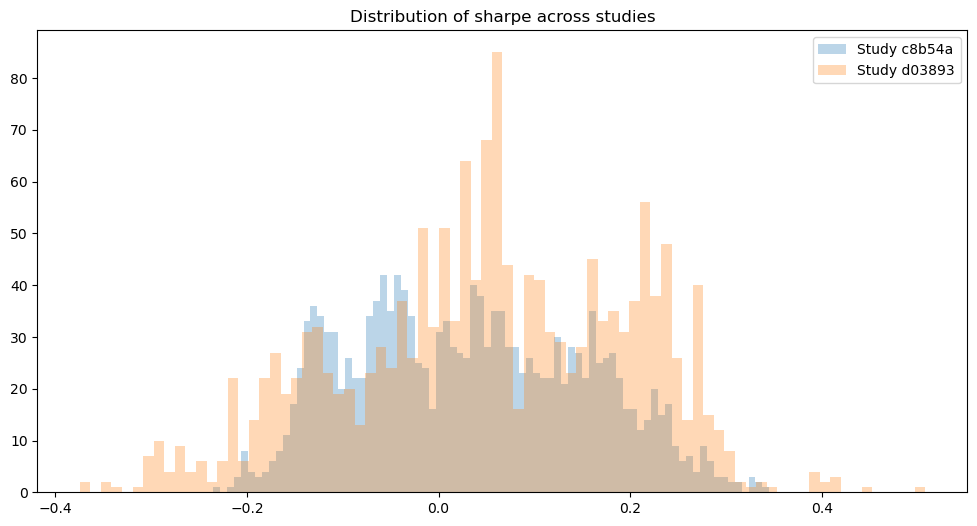

In [3]:
import matplotlib.pyplot as plt

def plot_metric_across_studies(metric_name):
    plt.figure(figsize=(12,6))
    for study in studies:
        df = study['df']
        if metric_name not in df.columns:
            continue
        plt.hist(df[metric_name], bins=80, alpha=0.3, label=f"Study {study['hash'][:6]}")
    plt.legend()
    plt.title(f"Distribution of {metric_name} across studies")
    plt.show()

# Example: Compare sharpe distributions
plot_metric_across_studies("sharpe")